# Gender Model

I believe the model for this would be quite straightfoward as there are only 2 classes and the classes are quite balanced, as mentioned in the EDA notebook. Hence, if the model gives an accuracy above 80%, it will be satisfactory for me, so that I can spend more time on the age classification model which has turned out to be alot more complex. 

With this, I will be training the dataset on the baseline CNN model using the RGB and Grayscale dataset. 

After which, the model with the highest accuracy will be saved for use later for video and image detection.

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import sklearn

from google.colab.patches import cv2_imshow
from google.colab import files
from skimage import io
from PIL import Image

import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

In [ ]:
!tar -xvf "/content/drive/MyDrive/dataset/UTKFace.tar" -C "/content"     #[run this cell to extract tar files]

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [ ]:
# Exporting created dataframe as a CSV file.

main_df = pd.read_csv("/content/drive/MyDrive/dataset/main_dataset.csv")

In [ ]:
main_df.head()

,filename,gender,age,age_class
0,/content/UTKFace/26_0_0_20170113210605010.jpg....,0,26,2
1,/content/UTKFace/35_0_0_20170117200544166.jpg....,0,35,3
2,/content/UTKFace/70_0_0_20170117173727535.jpg....,0,70,5
3,/content/UTKFace/1_1_3_20161220143234887.jpg.c...,1,1,0
4,/content/UTKFace/26_0_0_20170113210127395.jpg....,0,26,2


In [ ]:
# Check that the classes are correct
main_df['gender'].value_counts()

0    12391
1    11317
Name: gender, dtype: int64

# Gender CNN Model with Grayscale image

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = main_df[['filename']]
y = main_df['gender']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the shape of datasets
print(f'Train data shape {X_train.shape}')
print(f'Test data shape {X_test.shape}')
print(f'Train target shape {y_train.shape}')
print(f'Test target shape {y_test.shape}')


Train data shape (16595, 1)
Test data shape (7113, 1)
Train target shape (16595,)
Test target shape (7113,)


In [ ]:
# Check the distribution of y_train
y_train.value_counts(normalize=True)

0    0.522627
1    0.477373
Name: gender, dtype: float64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True)

0    0.522705
1    0.477295
Name: gender, dtype: float64

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 2

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(64)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(64)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

gender_cnn_1 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
gender_cnn_1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
gender_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
gender_cnn_1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
gender_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

gender_cnn_1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
gender_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

gender_cnn_1.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
gender_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
gender_cnn_1.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
gender_cnn_1.add(Dense(132, activation='relu'))

# Output layer with 2 nodes (equal to the no. of classes).
gender_cnn_1.add(Dense(2, activation='softmax'))

gender_cnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d_4 (Average (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_6 (Average (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 256)      

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

gender_cnn_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Colab Notebooks/logs/gender/gender_cnn_2")

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/Colab Notebooks/models/gender/gender_cnn_1_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model.

gender_cnn_1_history = gender_cnn_1.fit(train_dataset,
                                  batch_size=64,
                                  validation_data=test_dataset,
                                  epochs=30,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/30
260/260 [==============================] - 13s 50ms/step - loss: 0.4601 - accuracy: 0.7835 - val_loss: 0.4473 - val_accuracy: 0.7970

Epoch 00001: val_accuracy improved from 0.74779 to 0.79699, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_1_checkpoint.h5
Epoch 2/30
260/260 [==============================] - 12s 47ms/step - loss: 0.4170 - accuracy: 0.8074 - val_loss: 0.4108 - val_accuracy: 0.8248

Epoch 00002: val_accuracy improved from 0.79699 to 0.82483, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_1_checkpoint.h5
Epoch 3/30
260/260 [==============================] - 12s 47ms/step - loss: 0.3899 - accuracy: 0.8239 - val_loss: 0.3924 - val_accuracy: 0.8328

Epoch 00003: val_accuracy improved from 0.82483 to 0.83284, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_1_checkpoint.h5
Epoch 4/30
260/260 [==============================] - 1

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = gender_cnn_1_history.history['loss']
test_loss = gender_cnn_1_history.history['val_loss']
train_accuracy = gender_cnn_1_history.history['accuracy']
test_accuracy = gender_cnn_1_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

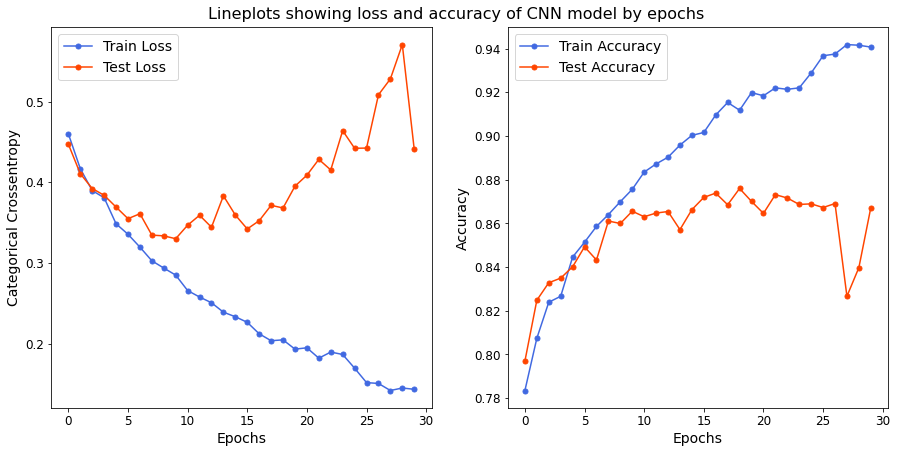

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16);

In [ ]:
# Evaluating the model on test dataset.

gender_cnn_1_score = gender_cnn_1.evaluate(test_dataset, verbose=1)

112/112 [==============================] - 2s 18ms/step - loss: 0.4409 - accuracy: 0.8671


In [ ]:
# Printing the relevant score summary.

gender_cnn_1_labels = gender_cnn_1.metrics_names
print(f'CNN_1 model {gender_cnn_1_labels[0]} \t= {round(gender_cnn_1_score[0], 3)}')
print(f'CNN_1 model {gender_cnn_1_labels[1]} \t= {round(gender_cnn_1_score[1], 3)}')

CNN_1 model loss 	= 0.441
CNN_1 model accuracy 	= 0.867


In [ ]:
# Generating predictions from the model above.

gender_cnn_1_pred = gender_cnn_1.predict(test_dataset)
gender_cnn_1_pred = gender_cnn_1_pred.argmax(axis=-1)

In [ ]:
len(gender_cnn_1_pred)

7113

In [ ]:
len(test_labels_list)

7113

In [ ]:
gender_cnn_1_cm = confusion_matrix(test_labels_list, gender_cnn_1_pred)

array([[3064,  654],
       [ 291, 3104]])

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['male','female']

plt.figure(figsize=(16,8))
plot_confusion_matrix(gender_cnn_1_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from Age model",
                      export_as="age_model_cnn_1_cm_normalized"
                     )

plt.show()

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['male','female']

plt.figure(figsize=(16,8))
plot_confusion_matrix(gender_cnn_1_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from Age model",
                      export_as="age_model_cnn_1_cm"
                     )

plt.show()

# Gender CNN Model with Coloured image

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 1 to 3 changes the output images from grayscale to RGB coloured.

num_classes = 2

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
#train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(64)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(64)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
train_dataset

<BatchDataset shapes: ((None, None, None, 3), (None, 2)), types: (tf.uint8, tf.float32)>

In [ ]:
# Defining the architecture of the sequential neural network.

gender_cnn_2 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
gender_cnn_2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 1 for grayscale images.
gender_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
gender_cnn_2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
gender_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

gender_cnn_2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
gender_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

gender_cnn_2.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
gender_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
gender_cnn_2.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
gender_cnn_2.add(Dense(132, activation='relu'))

# Output layer with 2 nodes (equal to the no. of classes).
gender_cnn_2.add(Dense(2, activation='softmax'))

gender_cnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_14 (Averag (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 256)      

In [ ]:
# Compiling the above created CNN architecture.

gender_cnn_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Colab Notebooks/logs/gender/gender_cnn_2")

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/Colab Notebooks/models/gender/gender_cnn_2_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model.

gender_cnn_2_history = gender_cnn_2.fit(train_dataset,
                                  batch_size=64,
                                  validation_data=test_dataset,
                                  epochs=30,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/30
260/260 [==============================] - 14s 50ms/step - loss: 1.0174 - accuracy: 0.6052 - val_loss: 0.6274 - val_accuracy: 0.6551

Epoch 00001: val_accuracy improved from -inf to 0.65514, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_2_checkpoint.h5
Epoch 2/30
260/260 [==============================] - 13s 48ms/step - loss: 0.6108 - accuracy: 0.6724 - val_loss: 0.6084 - val_accuracy: 0.6630

Epoch 00002: val_accuracy improved from 0.65514 to 0.66301, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_2_checkpoint.h5
Epoch 3/30
260/260 [==============================] - 12s 47ms/step - loss: 0.5829 - accuracy: 0.6920 - val_loss: 0.5804 - val_accuracy: 0.6938

Epoch 00003: val_accuracy improved from 0.66301 to 0.69380, saving model to /content/drive/My Drive/Age_Classification_with_Faces/input_output/gender_cnn_2_checkpoint.h5
Epoch 4/30
260/260 [==============================] - 12s 

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = gender_cnn_2_history.history['loss']
test_loss = gender_cnn_2_history.history['val_loss']
train_accuracy = gender_cnn_2_history.history['accuracy']
test_accuracy = gender_cnn_2_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

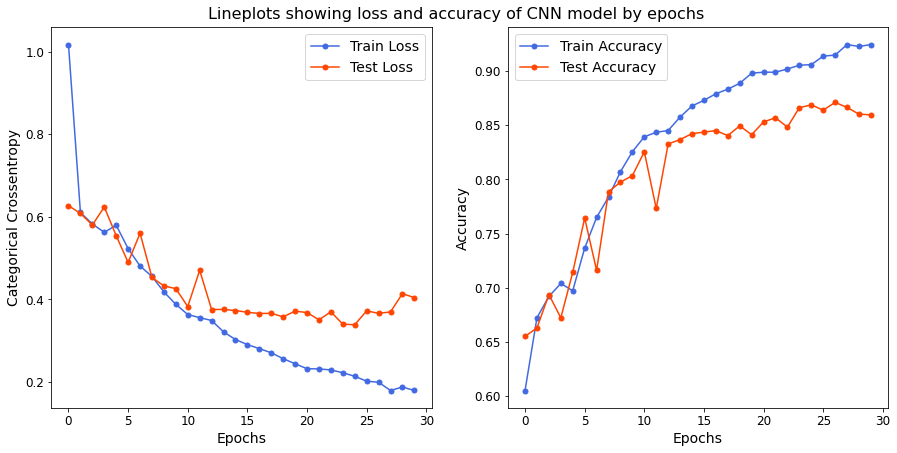

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [ ]:
# Evaluating the model on test dataset.

gender_cnn_2_score = gender_cnn_2.evaluate(test_dataset, verbose=1)

112/112 [==============================] - 2s 21ms/step - loss: 0.4043 - accuracy: 0.8596


In [ ]:
# Printing the relevant score summary.

gender_cnn_1_labels = gender_cnn_1.metrics_names
print(f'CNN_1 model {gender_cnn_1_labels[0]} \t= {round(gender_cnn_1_score[0], 3)}')
print(f'CNN_1 model {gender_cnn_1_labels[1]} \t= {round(gender_cnn_1_score[1], 3)}')

gender_cnn_2_labels = gender_cnn_2.metrics_names
print(f'CNN_2 model {gender_cnn_2_labels[0]} \t= {round(gender_cnn_2_score[0], 3)}')
print(f'CNN_2 model {gender_cnn_2_labels[1]} \t= {round(gender_cnn_2_score[1], 3)}')

CNN_1 model loss 	= 0.441
CNN_1 model accuracy 	= 0.867
CNN_2 model loss 	= 0.404
CNN_2 model accuracy 	= 0.86


In [ ]:
# Generating predictions from the model above.

gender_cnn_2_pred = gender_cnn_2.predict(test_dataset)
gender_cnn_2_pred = gender_cnn_2_pred.argmax(axis=-1)

In [ ]:
len(gender_cnn_2_pred)

7113

In [ ]:
len(test_labels_list)

7113

In [ ]:
confusion_matrix(test_labels_list, gender_cnn_2_pred)

array([[3071,  647],
       [ 352, 3043]])

# Model Selection

|Model|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
CNN with Grayscale Image|0.1995|0.3664|91.47%|87.11%
CNN with Coloured Image|0.2050|0.3683|91.18%|87.60%

The best model is the CNN with Grayscale Image with a test accuracy of 87.11%. I will be using this model for the video and image detection.